In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file = 'car.data'
columns = ['relative_cost', 'maint_cost', 'doors', 'persons', 'lug_boot', 'safety', 'rating']
data = pd.read_csv(file, names = columns)
data.head(20)

,relative_cost,maint_cost,doors,persons,lug_boot,safety,rating
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
5,vhigh,vhigh,2,2,med,high,unacc
6,vhigh,vhigh,2,2,big,low,unacc
7,vhigh,vhigh,2,2,big,med,unacc
8,vhigh,vhigh,2,2,big,high,unacc
9,vhigh,vhigh,2,4,small,low,unacc


# Evaluating Class Models

In [3]:
# EDA

# Make numeric version of data to be able to make correlations
num_data = pd.read_csv(file, names = columns)
num_data['relative_cost'].replace({'low':0,'med':1/3,'high':2/3, 'vhigh':1}, inplace = True)
num_data['maint_cost'].replace({'low':0,'med':1/3,'high':2/3, 'vhigh':1},inplace = True)
num_data['doors'].replace({'2':0,'3':1/3,'4':2/3,'5more':1},inplace = True)
num_data['persons'].replace({'2':0,'4':0.5,'more':1},inplace = True)
num_data['lug_boot'].replace({'small':0,'med':0.5,'big':1},inplace = True)
num_data['safety'].replace({'low':0,'med':0.5,'high':1},inplace = True)
num_data['rating'].replace({'unacc': 1, 'acc': 2, 'good': 3, 'vgood': 4}, inplace = True)

num_data.head()

,relative_cost,maint_cost,doors,persons,lug_boot,safety,rating
0,1.0,1.0,0.0,0.0,0.0,0.0,1
1,1.0,1.0,0.0,0.0,0.0,0.5,1
2,1.0,1.0,0.0,0.0,0.0,1.0,1
3,1.0,1.0,0.0,0.0,0.5,0.0,1
4,1.0,1.0,0.0,0.0,0.5,0.5,1


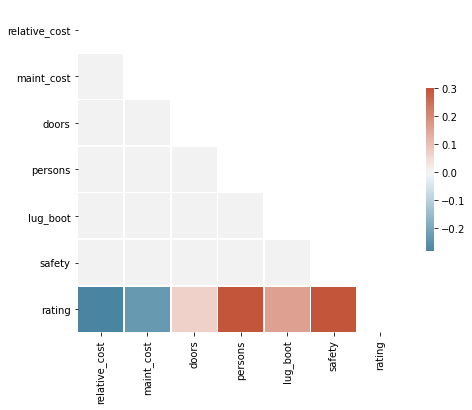

In [4]:
# Visualize correlation
corr = num_data.corr()
datacorr = corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f,ax = plt.subplots(figsize=(8,6))
cmap = sns.diverging_palette(230, 20, as_cmap = True)
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, center = 0, square = True, linewidths = 0.5, cbar_kws = {"shrink": 0.5})

This makes sense:
- Rating is inversely correlated with relative-cost (higher cost means lower rating).
- Same with maintenence costs.
- More doors is slightly correlated with rating, but not as important.
- More persons means a higher rating, which makes sense because you get more value out of the car.
- Bigger boot space means more value in the car.
- Safety is always important, so higher safety ratings indicate better ratings.

In [4]:
# Baseline accuracy
data['rating'].value_counts(normalize = True)

unacc    0.700231
acc      0.222222
good     0.039931
vgood    0.037616
Name: rating, dtype: float64

In [5]:
scores = {'Logistic': {}, 'SVM': {}, 'NB': {}, 'KNN': {}}

# Logistic Regression

In [6]:
# Set targets and features
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [7]:
# Change features to numeric
X.iloc[:,0:2].replace({'low':0,'med':1/3,'high':2/3, 'vhigh':1}, inplace = True)
X.iloc[:,2].replace({'2':0,'3':1/3,'4':2/3,'5more':1},inplace = True)
X.iloc[:,3].replace({'2':0,'4':0.5,'more':1},inplace = True)
X.iloc[:,4].replace({'small':0,'med':0.5,'big':1},inplace = True)
X.iloc[:,5].replace({'low':0,'med':0.5,'high':1},inplace = True)

C:\Users\Joel\anaconda3\lib\site-packages\pandas\core\frame.py:4166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [8]:
# Partition the data into training and testing subsets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn import preprocessing


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=17)

In [9]:
# Build model
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', penalty = 'l2')

# fit model
lr.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

In [10]:
# Check accuracy of model
from sklearn.metrics import roc_auc_score


roc_score = roc_auc_score(y_test, lr.predict_proba(X_test), multi_class = 'ovr')

print('Model Score: ', lr.score(X_test, y_test))

Model Score:  0.838150289017341


In [11]:
from sklearn.metrics import classification_report
y_pred = lr.predict(X_test)
y_true = y_test
target_names = ['acc', 'good', 'unacc', 'vgood']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         acc       0.69      0.61      0.64        76
        good       0.75      0.33      0.46        18
       unacc       0.88      0.96      0.92       243
       vgood       1.00      0.44      0.62         9

    accuracy                           0.84       346
   macro avg       0.83      0.59      0.66       346
weighted avg       0.83      0.84      0.83       346



In [12]:
scores['Logistic']['Accuracy'] = 'Model Score: 0.838'
scores['Logistic']['f_score'] = '0.83'

for i, x in scores.items():
    print(i, ': ', x)

Logistic :  {'Accuracy': 'Model Score: 0.838', 'f_score': '0.83'}
SVM :  {}
NB :  {}
KNN :  {}


In [13]:
y_pred = lr.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points: %d"
     % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 346 points: 56


# SVM

In [14]:
# SVM
from sklearn import svm
from sklearn.svm import SVC

svmodel = svm.SVC(C = 1, gamma = 1, probability = True)
svmodel.fit(X_train, y_train)

# Score model
svscore = svmodel.score(X_test, y_test)
print('Model Score: ', svscore)


Model Score:  0.9682080924855492


In [15]:
# classification report
y_pred = svmodel.predict(X_test)
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         acc       0.94      0.96      0.95        76
        good       0.92      0.67      0.77        18
       unacc       0.99      0.99      0.99       243
       vgood       0.75      1.00      0.86         9

    accuracy                           0.97       346
   macro avg       0.90      0.90      0.89       346
weighted avg       0.97      0.97      0.97       346



In [16]:
scores['SVM']['Accuracy'] = 'Model Score: 0.968' 
scores['SVM']['f_score'] = '0.97'
for i, x in scores.items():
    print(i, ': ', x)

Logistic :  {'Accuracy': 'Model Score: 0.838', 'f_score': '0.83'}
SVM :  {'Accuracy': 'Model Score: 0.968', 'f_score': '0.97'}
NB :  {}
KNN :  {}


In [17]:
y_pred = svmodel.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points: %d"
     % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 346 points: 11


# Naive Bayes

In [18]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Score model
gnbscore = gnb.score(X_test, y_test)
gnb_roc = roc_auc_score(y_test, gnb.predict_proba(X_test), multi_class = 'ovr')
print('Model Score: ', gnbscore)

Model Score:  0.6936416184971098


In [19]:
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points: %d"
     % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 346 points: 106


In [20]:
y_pred = gnb.predict(X_test)
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         acc       0.59      0.13      0.22        76
        good       0.50      0.11      0.18        18
       unacc       0.84      0.90      0.87       243
       vgood       0.14      1.00      0.24         9

    accuracy                           0.69       346
   macro avg       0.52      0.54      0.38       346
weighted avg       0.75      0.69      0.67       346



In [32]:
scores['NB']['Accuracy'] = 'Model Score: 0.69'
scores['NB']['f_score'] = '0.67'
for i, x in scores.items():
    print(i, ': ', x)

Logistic :  {'Accuracy': 'Model Score: 0.838', 'f_score': '0.83'}
SVM :  {'Accuracy': 'Model Score: 0.968', 'f_score': '0.97'}
NB :  {'Accuracy': 'Model Score: 0.69', 'f_score': '0.67'}
KNN :  {}


# K Nearest Neighbors

In [22]:
%%time
from sklearn.neighbors import KNeighborsClassifier

# Find optimal number of neighbors
test_accuracy = []
num_neighbors = []
for i in range(1,100):
    num_neighbors.append(i)
    
for i in range(1, 100):
    clf = KNeighborsClassifier(n_neighbors = i)
    clf.fit(X_train, y_train)
    test_accuracy.append(clf.score(X_test, y_test))
    
print(test_accuracy)

[0.9017341040462428, 0.9046242774566474, 0.9566473988439307, 0.930635838150289, 0.9450867052023122, 0.9335260115606936, 0.9393063583815029, 0.9277456647398844, 0.930635838150289, 0.9277456647398844, 0.9277456647398844, 0.9335260115606936, 0.930635838150289, 0.9421965317919075, 0.9364161849710982, 0.9335260115606936, 0.9277456647398844, 0.9190751445086706, 0.9248554913294798, 0.9335260115606936, 0.9190751445086706, 0.9190751445086706, 0.9335260115606936, 0.9277456647398844, 0.9219653179190751, 0.9161849710982659, 0.9190751445086706, 0.9190751445086706, 0.9104046242774566, 0.9104046242774566, 0.9017341040462428, 0.9017341040462428, 0.9017341040462428, 0.9104046242774566, 0.9046242774566474, 0.9104046242774566, 0.9017341040462428, 0.9046242774566474, 0.8901734104046243, 0.8930635838150289, 0.8988439306358381, 0.8959537572254336, 0.8872832369942196, 0.8930635838150289, 0.8872832369942196, 0.8930635838150289, 0.8959537572254336, 0.8901734104046243, 0.8901734104046243, 0.8988439306358381, 0.

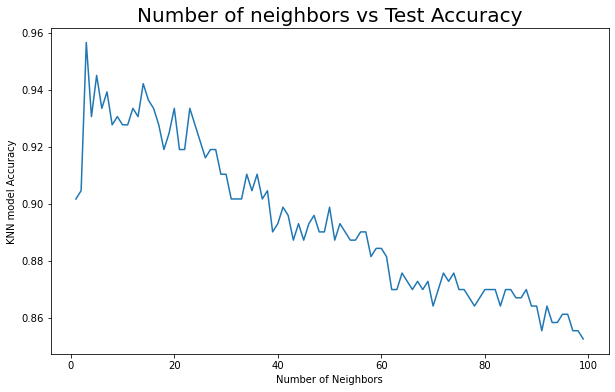

In [23]:
plt.figure(figsize = (10,6))
plt.plot(num_neighbors, test_accuracy)
plt.title('Number of neighbors vs Test Accuracy', fontsize = 20)
plt.xlabel('Number of Neighbors')
plt.ylabel('KNN model Accuracy')
plt.show()

We can see that number of K optimizes at around 5-7

In [27]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

# Score model
Knnscore = clf.score(X_test, y_test)
gnb_roc = roc_auc_score(y_test, clf.predict_proba(X_test), multi_class = 'ovr')
print('Model Score: ', Knnscore)

Model Score:  0.9450867052023122


In [28]:
y_pred = clf.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points: %d"
     % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 346 points: 19


In [29]:
y_pred = clf.predict(X_test)
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         acc       0.85      0.91      0.88        76
        good       0.93      0.78      0.85        18
       unacc       0.98      0.97      0.98       243
       vgood       0.80      0.89      0.84         9

    accuracy                           0.95       346
   macro avg       0.89      0.89      0.89       346
weighted avg       0.95      0.95      0.95       346



# Model Comparison

In [33]:
scores['KNN']['Accuracy'] = 'Model Score: 0.945'
scores['KNN']['f_score'] = '0.95'
for i, x in scores.items():
    print(i, ': ', x)

Logistic :  {'Accuracy': 'Model Score: 0.838', 'f_score': '0.83'}
SVM :  {'Accuracy': 'Model Score: 0.968', 'f_score': '0.97'}
NB :  {'Accuracy': 'Model Score: 0.69', 'f_score': '0.67'}
KNN :  {'Accuracy': 'Model Score: 0.945', 'f_score': '0.95'}


In [61]:
comparison = [[0.838, 0.83], [0.968, 0.97], [0.69, 0.67], [0.945, 0.95]]
col_names = [ 'Accuracy_Score', 'f_score']
index_names = ['Logistic Reg', 'SVM', 'NB', 'KNN']
comparison = pd.DataFrame(comparison, index = index_names, columns = col_names)
comparison

,Accuracy_Score,f_score
Logistic Reg,0.838,0.83
SVM,0.968,0.97
NB,0.690,0.67
KNN,0.945,0.95


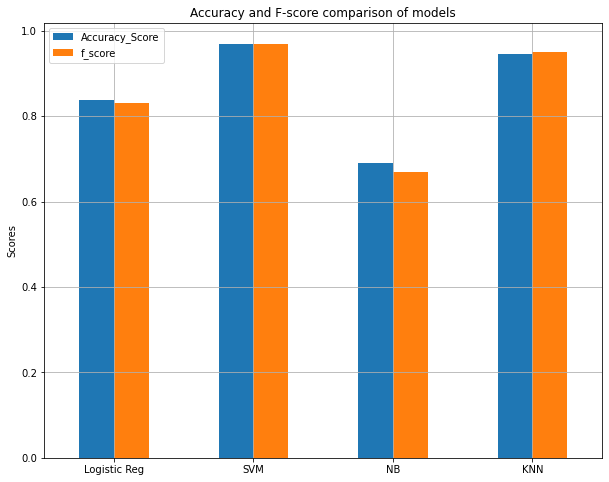

In [73]:
comparison.plot.bar(rot = 0, figsize = (10,8), grid = True)
plt.ylabel('Scores')
plt.legend(loc = 'best')
plt.title('Accuracy and F-score comparison of models')
plt.show()

# Making a prediction
Make classification of car deals near me for Suburu WRX.
Source of model information:(https://www.carsales.com.au/cars/subaru/wrx/?Sort=NearestNeighbour%2C-33.759228%2C150.967346)

In [77]:
prices = [32000, 50880, 51990, 27500, 58000, 28880, 49888, 31488, 29785, 36000, 27500, 39380]
avg_price = np.mean(prices)
print(avg_price)
print(np.std(prices))

38607.583333333336
10622.226394517718


We will make the following classifications on relative price:
- low = below 1 standard deviation (-28k)
- med = within 1 standard deviation (28 - 48k)
- high = between 1 and 1.4 standard deviations (48 - 52k)
- v-high = above 1.2 standard deviations (+ 52k)

WRX has:
- 50k price
- 1.5k-2k maintence cost p.a (medium)
- 4 doors
- 5 person capacity
- medium sized boot
- 5 star ancap rating (maxed)

In [ ]:
num_data['relative_cost'].replace({'low':0,'med':1/3,'high':2/3, 'vhigh':1}, inplace = True)
num_data['maint_cost'].replace({'low':0,'med':1/3,'high':2/3, 'vhigh':1},inplace = True)
num_data['doors'].replace({'2':0,'3':1/3,'4':2/3,'5more':1},inplace = True)
num_data['persons'].replace({'2':0,'4':0.5,'more':1},inplace = True)
num_data['lug_boot'].replace({'small':0,'med':0.5,'big':1},inplace = True)
num_data['safety'].replace({'low':0,'med':0.5,'high':1},inplace = True)
num_data['rating'].replace({'unacc': 1, 'acc': 2, 'good': 3, 'vgood': 4}, inplace = True)

In [81]:
lr.predict(np.array([[2/3, 1/3, 2/3, 1, 0.5, 1]]))[0]

'acc'